# WestNileVirus

https://www.kaggle.com/c/predict-west-nile-virus

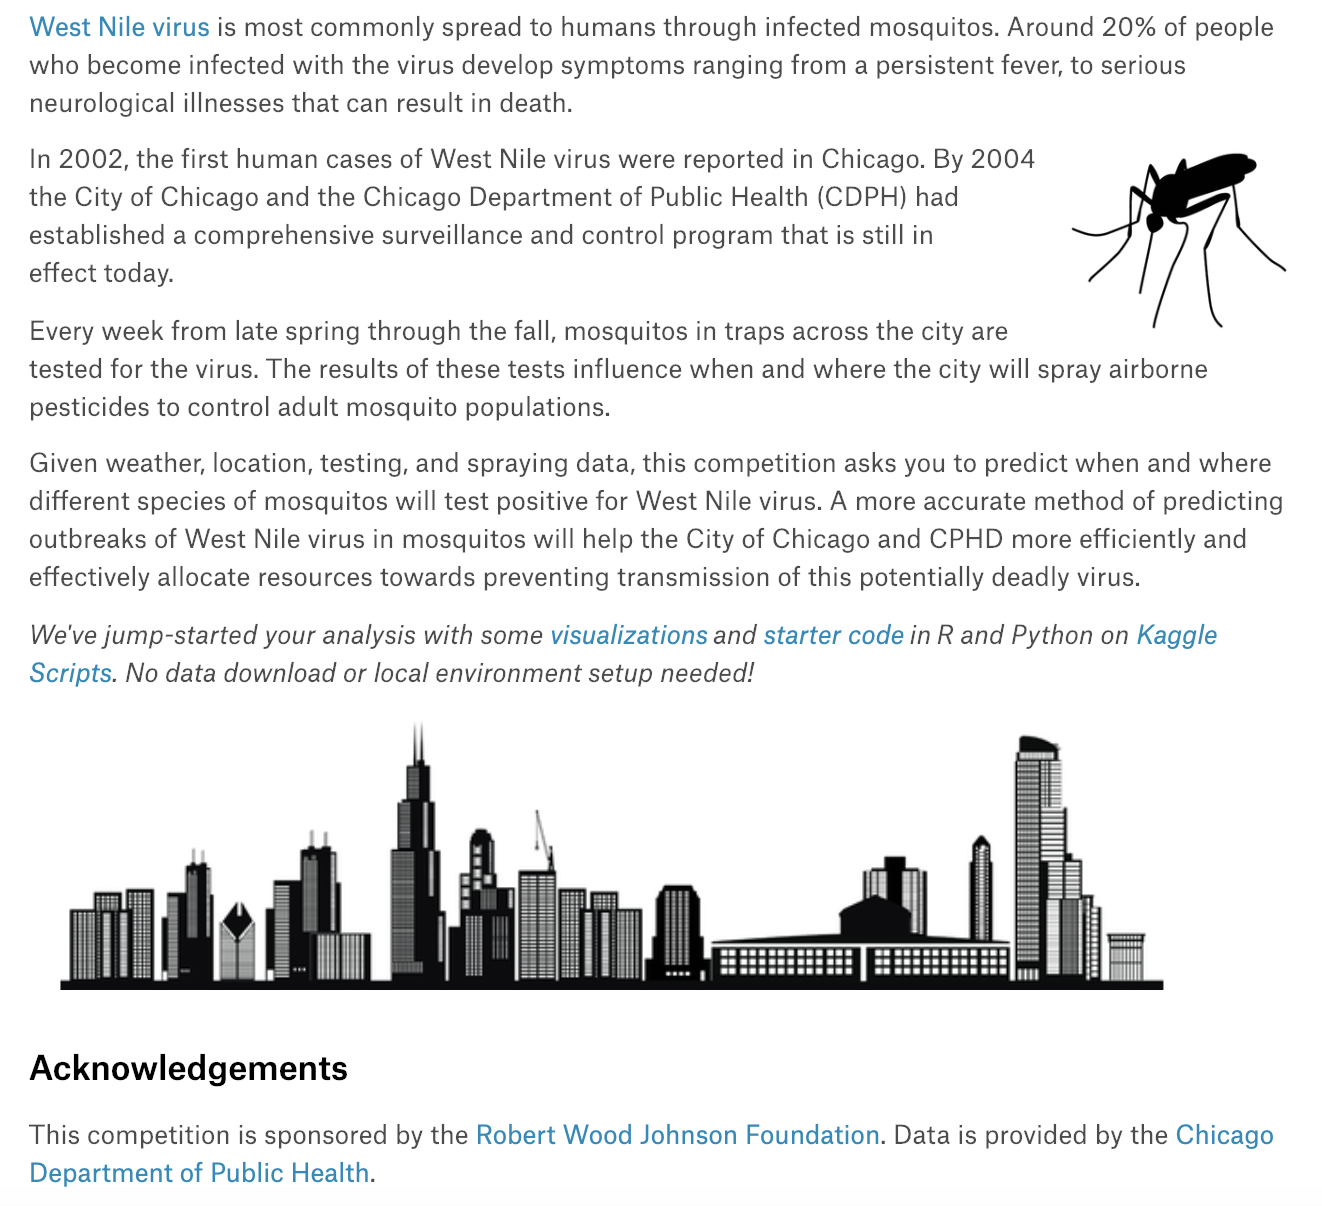

#### First, let's run the 'WNVdataEng.py' that processes all the datasets, and has all the data engineering documentation

In [1]:
# turn the expression into True to run the cell:
if 1==1:
    %run /Users/eran/Galvanize_more_repositories/WestNileVirus/WNVdataEng.py

In [10]:
import numpy as np
import pandas as pd
import statistics as st
import os

In [2]:
directory_path="/Users/eran/Galvanize_more_repositories/WestNileVirus/all/"
directory_path

'/Users/eran/Galvanize_more_repositories/WestNileVirus/all/'

Read in the data

In [3]:
train_csv=os.path.join(directory_path, "train.csv")

In [4]:
# Reading in the train data
train=pd.read_csv(train_csv)

## Train Data EDA

In [1050]:
train.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


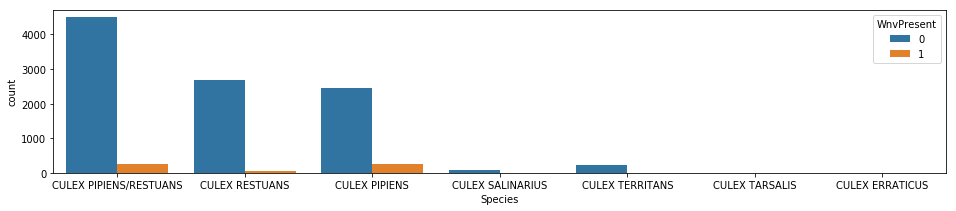

In [1013]:
# Let's start by looking at Species: 
# make new train with dummies for species
# pd.get_dummies(train,columns=['Species'],drop_first=True)
plt.subplots(figsize=(16,3))
iii=sns.countplot('Species',data=train,hue='WnvPresent',)

TOP - 
* looking at bars of every specie whether it has virus in orange or not in blue (to see if there is relationship between the species and the appearence of virus)
* seems that only 3 species are really prevalent.
* "Culex Pipiens" has the highest relative portion of WNtV ~10% 

In [705]:
train2=train1.copy()
train2['month']=train1['Date'].apply(lambda x: x.to_pydatetime().month)
train2['year']=train1['Date'].apply(lambda x: x.to_pydatetime().year)
train2['Day_of_week']=train1['Date'].apply(lambda x: x.to_pydatetime().weekday())

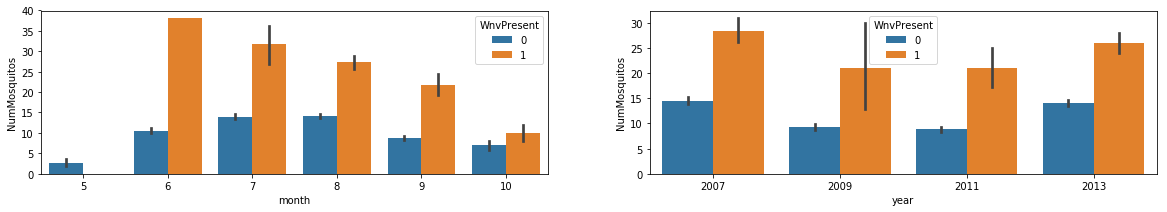

In [1014]:
plt.subplots(figsize=(20,3))
plt.subplot(1,2,1),sns.barplot('month','NumMosquitos',data=train2,hue='WnvPresent')  #,fit_reg=False
iii=plt.subplot(1,2,2),sns.barplot('year','NumMosquitos',data=train2,hue='WnvPresent')  #,fit_reg=False

TOP -
* number of mosquitos peaks on June and reduced as the summer progresses.
* different years have different number of mosquitos (highest in 2007). This is probably due to hot years 

In [1015]:
# this cell is reserved for map of Chicago with occurences
#sns.lmplot('Longitude','Latitude',data=train2,hue='WnvPresent',fit_reg=False,markers=['o','+'],height=7.5,aspect=0.71,legend_out=False)

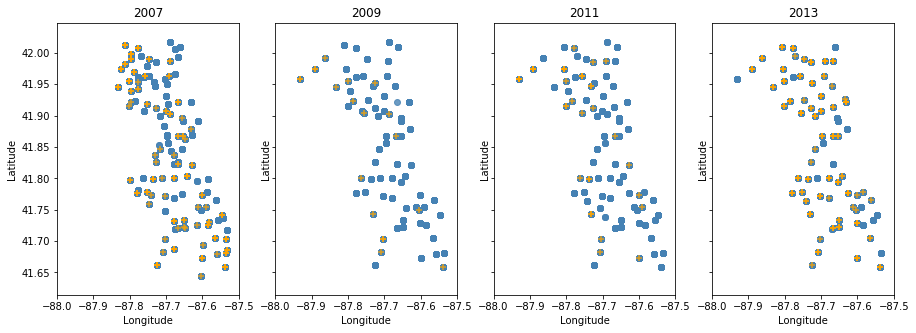

In [899]:
pltloglat(year) ## look at WNVdataEng for documentation

Using Ad Hoc function to plot WHERE and WHEN traps were collected, and which of them had the VIRUS?

Year - 2007


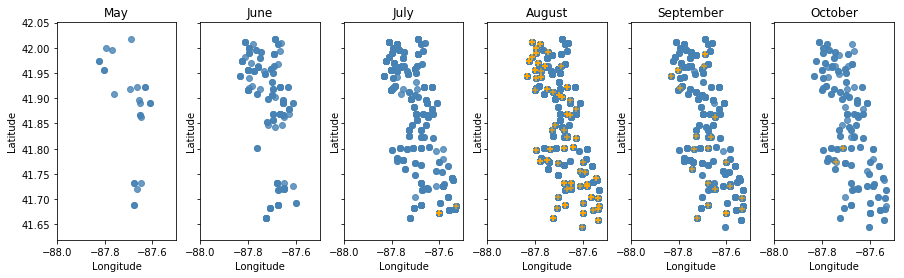

In [898]:
pltloglat(month,yearr=2007) ## look at WNVdataEng for documentation

### Baseline Modelling 
* Let's make an intial predictive model with the data we have, to establish baseline performance.
* Once we engineer and enrich the dataset, we will model it again and compare its performance to this baseline perfornmnce. 

In [1038]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [1022]:
# importing clean train dataset that was saved earlier (for documentation look at WNVdataEng.py)
train_base=pd.read_csv(os.path.join(directory_path,'train_baseline.csv'))
train_base.drop('Unnamed: 0',1,inplace=True)

In [1026]:
Xtn,Xst,ytn,yst=train_test_split(train_base.drop('WnvPresent',1),train_base['WnvPresent'],test_size=0.2,random_state=42,stratify=train['WnvPresent'])

In [1040]:
# running K-nearest neighbors model, 25 times with 25 different Ks to see the effect on accuracy, precision and recall  
recscore=[]
accurscore=[]
prescore=[]
prd=[]
k=list(range(1,25))
for i in k:
    knnn=KNeighborsClassifier(n_neighbors=i)
    knnn.fit(Xtn,ytn)
    yypred=knnn.predict(Xst)
    prd.append(yypred)
    prescore.append(precision_score(yypred,yst))
    recscore.append(recall_score(yypred,yst))
    accurscore.append(accuracy_score(yypred,yst))

array([[1991,  107],
       [   1,    3]])

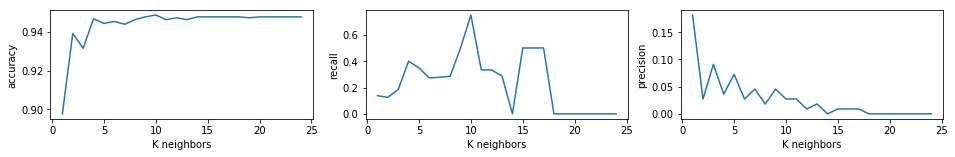

In [1045]:
## plotting the K-depended results of the metrics
plt.subplots(figsize=(16,2))
met={'accuracy':accurscore,'recall':recscore,'precision':prescore}
for num,key in enumerate(met):
    plt.subplot(1,3,num+1)
    plt.plot(k,met[key])
    plt.xlabel('K neighbors')
    plt.ylabel(key)
confusion_matrix(prd[9],ytest)

TOP LEFT - 
* accuracy starts really high and goes even higher when increasing the bias (i.e."generelizing" the model, by using even higher kNeighbors) this is typical for an imbalanced dataset (virus occurences are rare -> WNV=1 is 5%)
* because of the scarcity of incidence of WMV, the model is not better than a "dumb" model of predicting WNV=0 ("No VIrus") every time

TOP MIDDLE & RIGHT  - 
* We can see that when we increase the bias (Ks) recall is improving peaking at k=10 but that's at the expense of precision that drops to around 4% at K=10

Matrix - 
* this tradof is typical. when the K=10 we have 1 case of FN and 3 cases of TP which makes the recall peak at 75% but with 107 cases of FN this gives a very low precision ~4%, so the model is sensitive but is entirely not precise

#### Next we will look for other datasets to enrich the train data to imporve our predictive performance..

## Spray Data EDA

#### Rational: 
#### assumption - recently sprayed areas would most likely reduce frequency in WNV for the same season. 
If Chicago Municipality, would like to know how to allocate sparying efforts (or any other eradication efforts for that matter), we should filter out the effect of recent spraying from our predictive model, as it is target-linked.
#### Method: find obsevations (collections on Train data) with locations that have been sprayed in the past 150 days ( length of a season of collection from May to Oct), and exclude them from the data sets used for modelling 

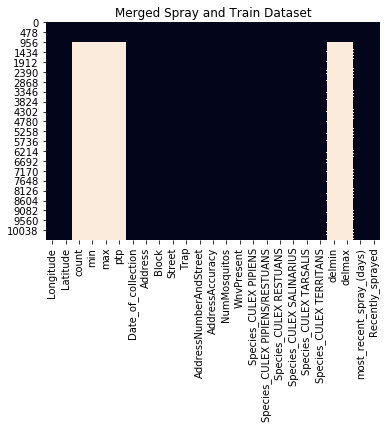

In [995]:
sns.heatmap(sptrain.isnull(),cbar=False)
iii=plt.title('Merged Spray and Train Dataset')

TOP
* data sets were merged according to loocations. spray data was engineered to several features: e.g. 'Recently_Sprayed' etc.. 
* the heatmap shows the top 962 entries being observations with spray data (rows in uniform black)
* the rest of the observations were sites that were not sprayed

number of observations from locations that were sprayed at the same season: 79


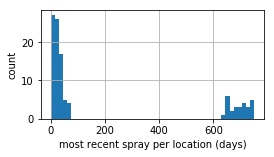

In [996]:
print('number of observations from locations that were sprayed at the same season:',sum(sptrain['Recently_sprayed']))
sptrain.loc[0:,'most_recent_spray_(days)'][sptrain.loc[0:,'most_recent_spray_(days)']<3650].hist(bins=50,figsize=(4,2))
plt.xlabel('most recent spray per location (days)')
iii=plt.ylabel('count')

TOP
* Seems like locations were either sprayed 2 years ago (around 700 days bars) or in this season (last 80 days).
* This is the data that could be target-linked that we need to be cautious with.

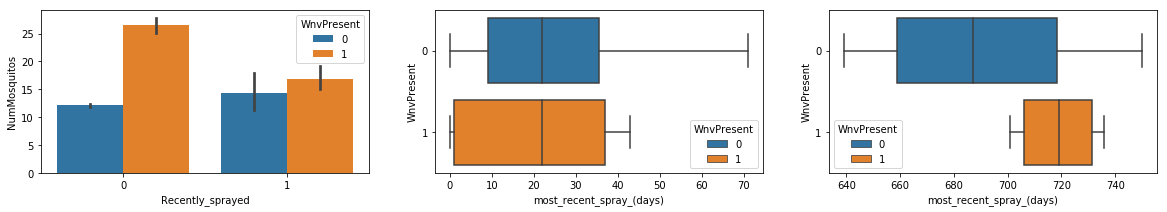

In [985]:
plt.subplots(figsize=(20,3))
plt.subplot(1,3,1),sns.barplot('Recently_sprayed','NumMosquitos',data=sptrain,hue='WnvPresent')  #,fit_reg=False
plt.subplot(1,3,2),sns.boxplot(y='WnvPresent', x='most_recent_spray_(days)', hue='WnvPresent', data=sptrain[(sptrain['most_recent_spray_(days)']<100)], dodge=False,orient="h")
iii=plt.subplot(1,3,3),sns.boxplot(y='WnvPresent', x='most_recent_spray_(days)', hue='WnvPresent', data=sptrain[(sptrain['most_recent_spray_(days)']>100)&(sptrain['most_recent_spray_(days)']<3600)], dodge=False,orient="h")

TOP LEFT -
* when locations are recently sprayed the average number of mosquitos is lower for WNV positive traps

TOP MIDDLE -
* But when we look at the virus occurences depended on how many days have past since the last spray we see that on average the days since the last spray have no effect on whether there will be a virus (although we can see that there are more occurences of viruses with traps that were sprayed 10 days ago and less)

TOP RIGHT -
* When we do the same for locations that were sprayed 2 years ago, interestingly there is an effect on the virus occurences depended on how many days have past: When more time had past, there are more virus occurences. 

### Spray data EDA Conclusion
* We could have expected that recently sprayed sites would have less of the virus.
* But the data does not show that effect (on average).
* #### moreover, when we look at the distribution, the more recently sprayed, the more there is a virus. A possible explanation is that the Recently_Sprayed feature is "target-linked" e.g. locations that are sprayed, are renowned to be infested in the first place, and that's why the are sprayed. In this since we mustn't use these observations in our prediction because then the prediction would be depended on whether we know already about locations that are prone to have WNV, which is exactly what we are trying to predict in the first place.

## Weather Data 

### Background

From Kaggle:
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests.

From '/Users/eran/Galvanize_more_repositories/WestNileVirus/all/noaa_weather_qclcd_documentation.pdf':
    - Dew point is an accurate measurement of humidity (indipendant of Relative humidity) 60= uncomfortable, 70 very uncomfortable.
        https://minnesota.cbslocal.com/2012/07/17/good-question-whats-the-difference-between-dew-point-and-humidity/
    - M = missing data
    - "A lower wet bulb temperature means the air is drier and can hold more water vapor than it can at a higher wet bulb temperature."

### Weather EDA
- Find columns directly related to Hot and Dry <-> higher WNV virus
- try to engineer them 
- merge according to proximity to weather station And Date

Inorder to uncover relationships between weather variables and WNV response, several steps should be performed (Unlike with clean, and organized data such as train.csv):
    
* Weather data should be cleaned (refer to "weather" as the raw data and "weath_out" as clean data)
* weather data should be merged with train data in order to couple it with WNV response (refer to "sptrainW_day_of")
* Weather data should be processed in a sensible way by producing features that would offer added information, based on a rational e.g. mosquitos need continous dry and hot weather inorder to thrive so features should be summarized in segments of time e.g. 2 weeks. (refer to "eng_weath" as the engineered weather data, and to "sptrainW_14_day" as the engineered and merged data with train data)  

#### summary of features - post some EDA 
( {-/+} means hypothetical correlation to WNV response) :
- Dew point - is an accurate measurement of humidity (indipendant of Relative humidity) 60= uncomfortable, 70 very uncomfortable. {-}  
- Depart - Departure from normal expected (in temperatures) {?}
a lot of missing data (M)
- WetBulb - temps: the lower the dryer, "A lower wet bulb temperature means the air is drier {-}
- Heat and Cool - look like days in a month (mostly zero) {+/-} (maybe split)
- Depth - of snow. all is Zero or M (NaN) (variable should drop)
- CodeSum -Codes. Type 'str'. almost all related to cold / wet / stormy weather (top 8 most prevalent). empty is ' ' 1609 out of 2944 {-/+} (maybe split) empty might be normal days that are {+}
- PrecipTotal - all numbers except "T" (type string). can convert to 0.005 {-}
- ResultSpeed - vector sum of windspeed and direction. (keep as is) {+/-} 
- resultant direction - in tens of degrees (360 max) (keep as is) {+/-}
- AvgSpeed - 3 missing, use median to fill in the nissing values. (rest keep as is). {+/-}

### Weather Feature Engineering

In [589]:
# turn the expression into True to run the cell:
if 1==0:
    %run /Users/eran/Galvanize_more_repositories/WestNileVirus/WNVdataENG.py

Using get_summary function to feature engineer a variable:

* choosing a variable to engineer - e.g. 'ResultSpeed' - wind speed 
* getting a set of consecutive days data of that variable (e.g. 10) 
* creating the following summary:
    mean, std, median and outliers. The rational is that even one day of abnormal weather can effect the resulting mosquito population and therefore the WNV response.

In [587]:
get_summary(weather.loc[0:10,'ResultSpeed'])  ## look at func documentation in WNVdataENG.py

,ResultSpeed.mean,ResultSpeed.std,ResultSpeed.50%,ResultSpeed.mean-median,ResultSpeed.outliers_low,ResultSpeed.outliers_high
0,10.281818,4.19948,11.7,-1.418182,1,0


TOP

Example shows: outlier_low = 1 shows that there has been one abnormaly low wind day in the 10 day batch (calculated by z-score<-2)

'make_features' func

* takes weather data and creates features
* func is built on 'get_summary' func, to run through features of interest to create new features from them. 
* In our case the new features will be a summary of 14 days prior to trap collection, per variable. 
* for make features func documentation, look at WNVdataENG.py

features of interest:

In [588]:
int_feat=['Tmax', 'Tmin', 'Tavg', 'DewPoint', 
          'WetBulb','Heat', 'Cool', 'PrecipTotal', 'StnPressure',
          'ResultSpeed','ResultDir', 'AvgSpeed', 'weather_type_Norm']

Run the function to feature engineer weather data:

In [199]:
## warnning: this could take a while (approx 241 seconds)
## turn statement into True to run the function
if 1==0:
    eng_weath=make_features(weath_out,int_feat) 

## consolidating a final dataset for modelling:
* Merging "spray","train" and "14_day_Weather" data into 1 data set: 'sptrainW_14_days' (i.e. 'sp' + 'train' + 'W_14_day')
* merging the weather with train data according to 'weather station' and 'date of collection'
* saving the final dataset - '/Users/eran/Galvanize_more_repositories/WestNileVirus/sptrainW_14_days.csv'
* For all data engineering documentation - see WNVdataEng.py

In [609]:
os.path.join(directory_path,'sptrainW_14_days.csv')

'/Users/eran/Galvanize_more_repositories/WestNileVirus/sptrainW_14_days.csv'

### Finaly..
After consolidating, let's see if we can uncover interesting relationships between some features and WNV response

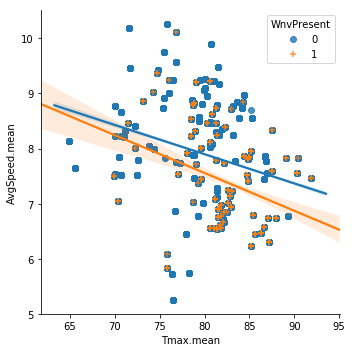

In [1008]:
iii=sns.lmplot('Tmax.mean','AvgSpeed.mean',data=sptrainW_14_days,hue='WnvPresent',markers=['o','+'],legend_out=False)

TOP- 
* WNV virus is correlated with high maximal temperatures and with lower wind speed

## Dimentionality Reduction visualization 
to visualize the feature space dependant WNV response

In [591]:
from sklearn.decomposition import PCA

In [605]:
pca=PCA(n_components=2)
pcaX=pca.fit_transform(sptrainW_14_days.drop(['WnvPresent','most_recent_spray_(days)'],1))
pcay=sptrainW_14_days['WnvPresent']
pcay.shape,pcaX.shape

((9296,), (9296, 2))

In [604]:
pcaXdf=pd.DataFrame(pcaX)
pcadf=pcaXdf.copy()
pcadf['pcay']=pcay
pcadf.rename(columns={0:'x0',1:'x1','pcay':'WNV_present'},inplace=True)

Text(0.5,1,'PCA (2 components)')

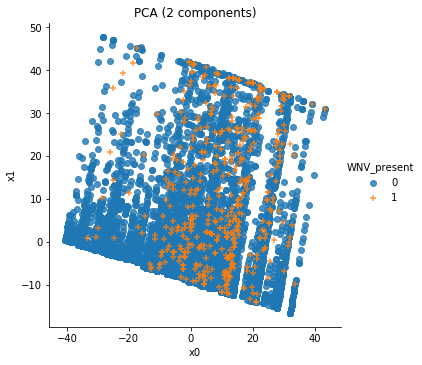

In [603]:
sns.lmplot('x0','x1',data=pcadf,hue='WNV_present',fit_reg=False,markers=['o','+'])
plt.title('PCA (2 components)')

* We can see that there isn't a definitive cluster of WNV response. However there is a higher frequency of WNV response in middle of the 2D space 
* Regardless, the graph is only for visualization purposes and therefore no conclusions could be drawn from it

### Dealling with the imbalnced data set
* Final step before modelling. 
* WNV occurence is scarce ~5%. This means that even a 'dumb model' of always predicting WNV=0, will achieve 95% accuracy.
* 'recall' and 'precision' and other metrics are a better fit, we'd be using them to test our model's performance
* Still, inorder to train our model a 5% minority response is not enough. Any given model would not be able to learn from it due to the overpowering effect of the majority of the data set
* There are several strategies to balance a dataset in order to train it, we will chose SMOTE

#### SMOTE
* Synthetic Minority Oversampling Technic (SMOTE)
* Using KNN to fabricate additional train data
* Spliting to train and test data first, and then using smote only on train data to avoid leakage of similar fabricated observations both in the train and the test (thus avoiding overfitting) 

In [16]:
from imblearn.over_sampling import SMOTE

ytrain imbalanced:


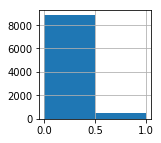

In [646]:
print('ytrain imbalanced:')
X_train=sptrainW_14_days.drop(['WnvPresent'],1)
y_train=sptrainW_14_days['WnvPresent']
p=y_train.hist(figsize=(2,2),bins=2)

ytrain balanced:


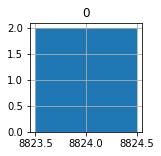

In [671]:
smt=SMOTE(random_state=42)
smtXtrain,smtytrain=smt.fit_sample(X_train,y_train)
print('ytrain balanced:')
p=pd.DataFrame(np.bincount(smtytrain)).hist(figsize=(2,2),bins=1)

# Modeling of the final engineered data
(with 14 day summary of weather till collection)

In [461]:
 # turn the expression into True to run the cell:
if 1==0:
    %run /Users/eran/Galvanize_more_repositories/WestNileVirus/WNVmodeling.py

The file: runs 3 models with arbitrary fixed hyperparameters (just to get a sense of performance)

* log_reg 
* KNN
* Random Forest Classifier)

on 4 different datasets (to see the effect of feature engineering on performance):

* 'baseline.imbalanced' that is cleaned train data with no engineering
* 'baseline that its minority response (WNV=1) is balanced to 1:1 ratio (using SMOTE)
* 'sptrainW_day_of' is enriched balanced train data (i.e. spray + train + weather data, where every observation (trap collection) is enriched with the weather of the same day
* 'sptrainW_14_day' same as 'sptrainW_day_of' where every observation is enriched with the summary of weather of the previous 2 weeks before collection.

It summarizes results with different metrics. we'll concentrate on AUC onder the ROC curve (AUCROC) and Recall. 

In [ ]:
oy=sss.T ## the df of metrics  (from file)
oy

(<matplotlib.axes._subplots.AxesSubplot at 0x1a32322320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a32322320>)

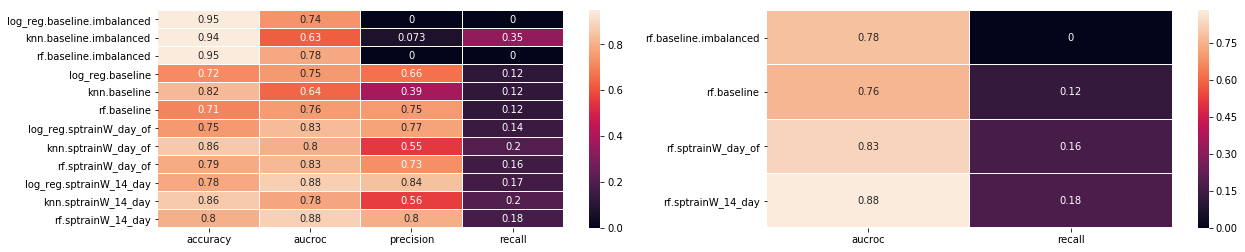

In [491]:
plt.subplots(figsize=(20,4))
plt.subplot(1,2,1),sns.heatmap(oy.loc[:,'accuracy':'recall'],linewidths=.05,annot=True)
plt.subplot(1,2,2),sns.heatmap(oy.iloc[[2,5,8,11],[5,7]],linewidths=.05,annot=True)

* TOP LEFT: Typical high accuracy of imbalanced (top left) is apperant together with zero precision and recall (top right). algorthm of "allways predict WNV=0" achieves same result
* TOP RIGHT: Gradually improved AUC and recall with feature engineering, looking at Random Forest only (Note recall is still very low) 

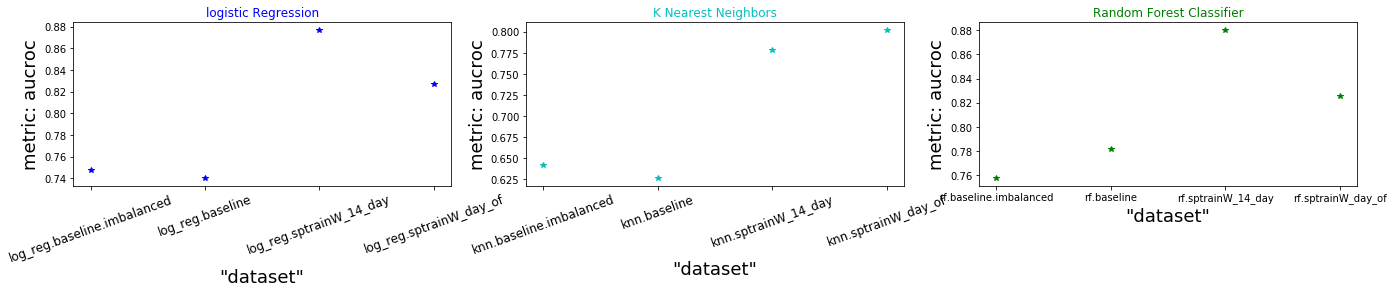

In [494]:
plt_met(mett='aucroc') ## look at func documaentation in WNVmodeling.py

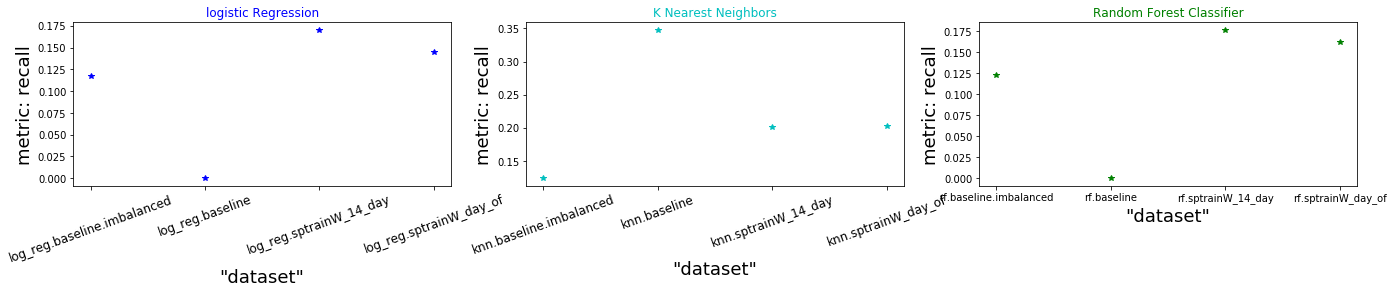

In [495]:
plt_met(mett='recall')

TOP: Best AUC and recall are acheived with the most engineered dataset (except when using KNN)

### Optimizing Hyperparameters:
continuing with the most engineered dataset (i.e. sptrainW_14_day) to optimize hyperparameters.

* using RF classifier - Although it is not better than Logistic Regression in performance, 
there are more hyperparameters that could be tuned to increase its perfomance.

Using Grid Search and Ad Hoc function 'grid_func': 
* to tune model for best recall, even on the expense of lowering precision (which is currently relatively high). This is because we care more about retrieving most WNV cases rather than avoid - Falsely predicting WNV. (For the purposes of Chicago minicipality the cost of missing a WNV case is much higher (due to health implications) than spraying an area falsly due to a mistake in WNV detection/prediction) 
* to tune model for best AUC ROC, we'll set our winning model on this result. AUC is superior because it will give us a score across all FP rate that we choose and therefore it is more robust (rather than a specific FPr score e.g. for a high recall) 

In [497]:
if 1==0:  
    GSrfRecall=grid_func('recall_score','sptrainW_14_day')  ## look at func documaentation in WNVmodeling.py
    GSrfAUC=grid_func('aucroc_score','sptrainW_14_day')

best params for aucroc_score
{'max_depth': 5, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 500}
confusion matrix adjusted for max aucroc_score
[[1519   23]
 [ 247   71]]


In [607]:
resultRec=pd.DataFrame(GSrfRecall.cv_results_)
resultAUC=pd.DataFrame(GSrfAUC.cv_results_)
### the best auc score placement in result df:
roww0=np.where(resultRec['mean_test_recall_score']==max(resultRec['mean_test_recall_score']))
roww1=np.where(resultAUC['mean_test_aucroc_score']==max(resultAUC['mean_test_aucroc_score']))
### give the winning row for highest AUC:
winRecallresult=resultRec.loc[roww0[0],[ 'mean_test_aucroc_score','mean_test_recall_score','mean_test_precision_score', 'mean_test_accuracy_score','param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']]
winAUCresult=resultAUC.loc[roww1[0],[ 'mean_test_aucroc_score','mean_test_recall_score','mean_test_precision_score', 'mean_test_accuracy_score','param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']]
winAUCresult.reset_index(inplace=True)
print('Best AUC score achieved:',round(winAUCresult['mean_test_aucroc_score'],2))
print('___________________________________')
print('Hyperparameters for best AUC score:')
winAUCresult[['param_max_depth','param_max_features','param_min_samples_split','param_n_estimators']]

Best AUC score achieved: 0    0.89
Name: mean_test_aucroc_score, dtype: float64
___________________________________
Hyperparameters for best AUC score:


,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
0,5,20,3,500


### Let's use these 'winning' parameters to run a RF model again, for further data analysis

In [531]:
rfwin=RandomForestClassifier(random_state=42,n_estimators=500,min_samples_split=3,max_features=20,max_depth=5)
rfwin.fit(Xtrain,ytrain)
predy=rfwin.predict(Xtest)
predprob=rfwin.predict_proba(Xtest)
fpr, tpr, thresholds = roc_curve(ytest, predprob[:,1])
precision, recall, threshol=precision_recall_curve(ytest, predprob[:,1])

roc_auc_score:  0.89
precision-recall_auc_score:  0.337


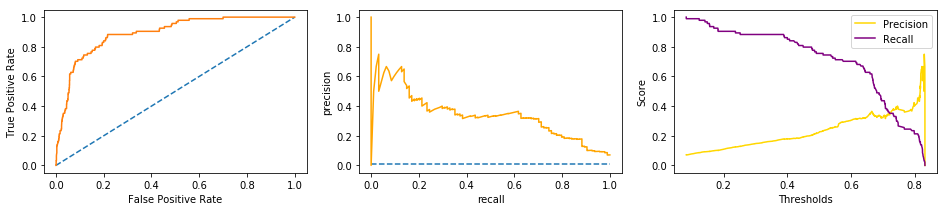

In [585]:
plt_curvs(ytest, predprob) ## look at func documentation in WNVmodeling.py

TOP-LEFT:
* Since we are interested in high recall rather then precision, we can choose a relatively high FP rate to (around 0.5, after th peak)

TOP-RIGHT:
* SImilarly threshold we can pick is 0.4 where recall is above 0.8 while precision is 0.2

### Feature importance:

* out of 90+ features, let's choose the ones with the strongest effect on WNV response 
* we choose a threshold of 0.01 to display ( to avoid showing all +90 features)

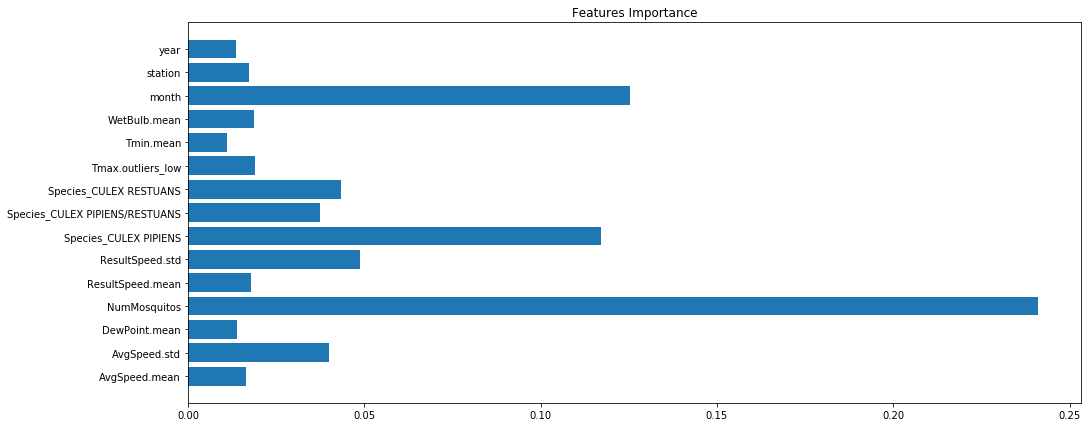

In [567]:
most=rfwin.feature_importances_[rfwin.feature_importances_>0.01]
collnum=np.where(rfwin.feature_importances_>0.01)
coll=sptrainW_14_days.drop('WnvPresent',1).columns[collnum]
plt.subplots(figsize=(16,7))
plt.barh(coll,most,)
j=plt.title('Features Importance')

#### Feature importance discussion:
    
* NumMosquitos, unsurprisingly nost important feature
* whether the specie is CULEX_PIPIENS or not, and the month in the year (e.g. summer) are also, unsurprisingly important
* From weather data, wind speed seems most important (probably strong winds effect the mosquitos)
* Humidity metrics have similar importance: i.e. wetbulb and dewpoint
* Cold metrics - if one of the days in the 2 weeks summarized had an extraordinary low 'Tmax' (Tmax.outliers.low), that probably lowered the chances for mosquitos
* Interestingly, there are definitly more occurences in specific areas in Chicago as could be infered from the station feature
* finally, some years have more occurences then other years

#### To make better sense of the effect these features have on WNV response, let's plot a heatmap of corelations. This way we'd be able to see the directionality of the correlation

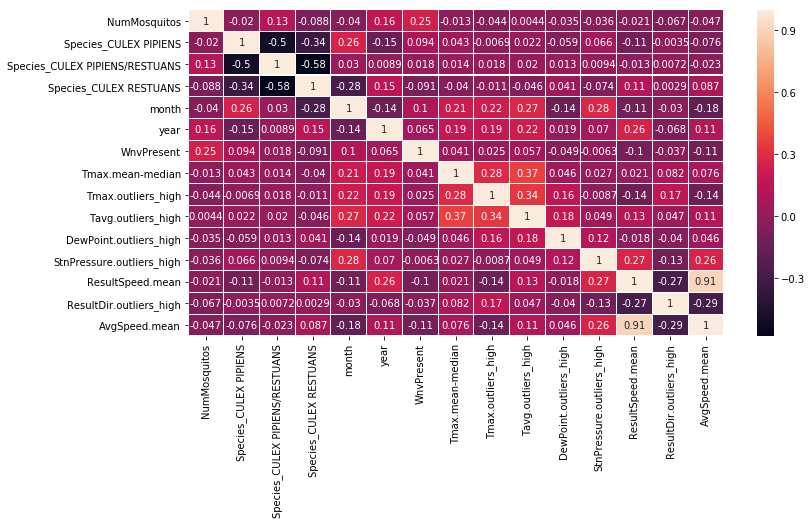

In [583]:
plt.subplots(figsize=(12,6))
collname=list(sptrainW_14_days.columns[collnum])
sns.heatmap(sptrainW_14_days[collname].corr(),linewidths=.05,annot=True)

TOP

* Indeed, all paraeters, regarding wind have negative correlation with WNV response meanning: More WINDY -> Less WNV.
* Dewpoint as well - More HUMID -> Less WNV (which is aligned with known facts about WNV that prefers dry conditions)
* Culex_Pipiens - most indicative of WNV response, Culex Restuans indicative of NO-WNV

# # #

- averaging weather data for a week/2 weeks before the collection (observation)
- repeat cleanning for test data ( make function: shit data in ready data out) (reintroduce sunrise/sunset)
- show effect of features engineering and re-balancing of the dasta set
PPT
- Nice EDA. hypothesis. feature engineering
- Explain Recall importance
- Enrich data with maps info on long-lat (e.g. swamp etc..)
- adjust weather info (mean weather for a week before)
- time series modeling? data set for every year?
- look at correlation between species. is there an actionable conclusion? releasing species that don't cary WNV to take the place of the others?